# MIGHTEE-HI Data Analysis: Moment Maps
***

By Wanga Mulaudzi and Sambatra Rajohnson

This notebook calculates the Moment 0 and Moment I maps for a number of detections. It then fits an ellipse the the Moment 0 map, and finally overlays the Moment 0 map on the SDSS image to assist with looking for an optical counterpart.

The Moment 0 map is the sum of emission along the frequency or velocity axis at each pixel, and describes the amount of gas at each pixel (proportional to the column density). It is calculated using

\begin{align}
M_0 = \int S\text{d}v.
\end{align}

The Moment I map describes the direction in which the HI gas is moving (it is the intensity-weighted velocity or frequency). It is given by

\begin{align}
M_I = \frac{\int vS\text{d}v}{S\text{d}v}.
\end{align}

First, we'll start off with import statements. It is important to import the ```distance_package``` python file for further calculations.

In [1]:
# Import statements
import aplpy
from astropy.io import ascii
from astropy.io import fits
from astropy import cosmology
from astropy.cosmology import WMAP7
from astropy import units as u
from astropy import constants as const
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astroquery.sdss import SDSS
from numpy.linalg import eig, inv
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import matplotlib.offsetbox
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
import math
import numpy.linalg as linalg
import numpy as np
import os
from pylab import *
import pylab as pl
from scipy.optimize import curve_fit
import scipy as sp
import seaborn as sns
import shutil
import sklearn
import spectral_cube
from spectral_cube import SpectralCube
from spectral_cube.cube_utils import Beam
import sys

# Importing distance_package
# Add path to distance_package to the system
dist_pkg_path = '/users/wanga/mightee/analysis'
sys.path.insert(1, dist_pkg_path)

import distance_package

In [2]:
# Initiate parameters for plotting
pl.rc('axes',titlesize='large')
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'serif','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'

## 1. User Inputs and Creating a Directory

In [3]:
# Path to your detection file list in an ASCII table format (e.g xxx.dat). Make sure it has RA, Dec and Freq columns
# Freq is the centre frequency of the detection in GHz
detections_list = '/users/wanga/mightee/source_finding/XMMLSS12_1_2.1380.UVCON1_notes_Wanga.dat'

# Path to the cube for the analysis
path_to_cube = '/idia/users/wanga/mightee/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.e.piwimed.pbcorr.fits'

# Path for new directory that will be created
dirName = '/users/wanga/mightee/analysis/XMMLSS12_1380/moment_maps_1380_analysis_output' 

#Extraction parameters
subcube_width = 2 # Size of the subcube in arcminutes
subcube_width_in_text = '2arcmin' # String format of the size of the subcube

# We may encounter detections that need a bigger or smaller subcube extraction, so you can select their index numbers:
list_index = [1, 2] # Detection 3
width_new = [1.1, 4]
width_new_in_text = ['1.1arcmin', '4arcmin']

# Convention for converting from frequency to velocity
velocity_convention = 'relativistic'

# Frequency width for the extraction
half_freq_width = 1e-3 # It is better to select a small frequency range for making moment maps

# Beam convolution parameters
circular_beam_axis = 20 # 20'' x 20'' circular beam

# Moment maps parameters
sigma = 3 # Masking 3*noise
mean_profile_width = 300 # km/s, needed for moment 1 map

# Channel map parameters
# All detections will have contours with 1e-4 increments apart from those specified
levels_index = [0, 1, 3] # Index of detection 
levels_val = [1e-4, 4e-5, 3e-4] # New levels for the detection

In [4]:
# Create a directory to store all the outputs
if not os.path.exists(dirName):
    os.makedirs(dirName)
    print("Directory ", dirName, " created.")
else:    
    print("Directory ", dirName, " already exists and will be overwritten.")
    shutil.rmtree(dirName)
    os.makedirs(dirName)

Directory  /users/wanga/mightee/analysis/XMMLSS12_1380/moment_maps_1380_analysis_output  already exists and will be overwritten.


In [5]:
# Inclinations from ellipses
# Open text file to write the inclinations to
incl_name = '/XMMLSS12_1380_inclinations' # Text file name
incl_file = open(dirName + incl_name, 'w+')

## 2. Subcube Extraction and Noise Estimation

Subcubes containing all the detections will be extracted from the main cube. They will be defined as the signal cubes, having a certain width w in arcminutes (depending on the detection size). Since the noise is varying locally in the cube, we can estimate the noise in the region on the right side of the signal cube, but making sure it contains no emission from the detection. This will be defined as the noise cube - a cube of the exact same size as the signal cube which used to estimate the local rms for each detection. 

![](noise_extraction.png)

In [6]:
# This function extracts the signal and noise cubes
def get_subcube_and_noisecube(cube, ra, dec, freq, width, velocity_convention='radio', noise_offset = 0.5*u.arcmin, dfreq=0.0005):
    '''
    cube is the cube used for the analysis
    ra is the ra of the detection in decimal degrees or hours, minutes and seconds
    dec is the dec of the detection in decimal degrees or degrees, minutes and seconds
    freq is the center frequency in GHz
    width is the size of the signal cube in arcminutes
    velocity_convention by default is the radio convention
    noise_offset is the amount added to the ra of the detection to get the ra of the noise cube
    dfreq is the offset from the centre frequency in GHz
    
    Outputs are:
    the signal cube with spectral axis frequency
    the signal cube with spectral axis velocity
    the frequency axis
    the velocity axis
    the flux density
    the noise cube with spectral axis velocity
    the detections coordinates
    '''
    # Lower and upper frequency limits
    freq_lower = '%.5fGHz' % (freq-dfreq) 
    freq_upper = '%.5fGHz' % (freq+dfreq)
    
    # Subcube extraction string
    crtf_str = 'centerbox[['+ra+','+dec+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    
    # Convert the RA and DEC into decimal degrees if not yet in decimal degrees
    coord = SkyCoord(ra, dec, unit='deg', frame='fk5')
    
    # RA and Dec for the noise cube. Need to shift the RA by the specified width
    ra_deg = coord.ra.deg + noise_offset.to(u.deg).value
    dec_deg = coord.dec.deg # Same declination as signal cube

    # Noise cube extraction
    noise_crtf = 'centerbox[['+str(ra_deg)+','+str(dec_deg)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'

    # Generating the new signal cube from the crtf_str region, spectral axis = frequency
    target_subcube = cube.subcube_from_crtfregion(crtf_str) 
    
    # Generating the corresponding noise cube from the noise_crtf region, spectral axis = frequency
    noise_subcube = cube.subcube_from_crtfregion(noise_crtf) 
    
    # Frequency axis in Hz
    freqs = target_subcube.spectral_axis 
    
    # Convert the signal and noise cubes spectral axes into velocity km/s in radio convention
    vel_subcube = target_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9*u.Hz)
    noise_velsubcube = noise_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9*u.Hz)
    
    # Velocity axis in km/s
    vel = vel_subcube.spectral_axis
    
    # Flux density values in Jy/beam
    target_spectrum_sum = target_subcube.sum(axis=(1,2))/target_subcube.unit
    
    return coord, target_subcube, vel_subcube, freqs, vel, target_spectrum_sum, noise_velsubcube, noise_subcube

## 3. Scale Bar

We need to calculate the scale bar for each detection to know the scale of the HI emission. The map is in pixels, and we know that for our imaging for example 1 pixel = 2 arcsec, so by knowing the distance of the galaxy by assuming a small angle, we will know the size of a pixel in parsecs.

In [7]:
# Function to calculate the redshift
def calc_z(nu):
    '''
    nu is the observed frequency in GHz
    
    Outputs are:
    the redshift
    '''
    nu_0 = (cube.header['RESTFRQ']*(u.Hz)).to(u.GHz).value # Rest frequency
    return (nu_0 - nu)/nu

In [8]:
# Function to convert arcsec to pc:
def angle_to_pc(x_arcsec, distance_Mpc):
    '''
    x_arcsec is the pixel size in arcsec
    
    Outputs are:
    distance in kpc
    '''
    D = x_arcsec*(u.arcsec.to(u.rad))*distance_Mpc
    return D.to(u.kpc)

In [9]:
# Function to convert frequency to velocity
def freq_to_vel(obs_freq):
    '''
    obs_freq is the center frequency
    
    Outputs are:
    the systemic velocity
    '''
    c = (299792458*(u.m/u.s)).to(u.km/u.s).value # Speed of light in km/s
    nu_0 = (cube.header['RESTFRQ']*(u.Hz)).to(u.GHz).value # Rest frequency
    
    vsys = (c*((pow(nu_0,2) - pow(obs_freq, 2))/(pow(nu_0,2) + pow(obs_freq, 2))))
    return vsys

In [10]:
# Making a scale bar for the data

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **kwargs)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **kwargs)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **kwargs)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon)

## 4. Moment maps

Steps for making moment maps:
* Convolve your cube into a common restoring beam: the bigger the restored beam is, the more sensitive to faint emission the cube will be. For that, we will convolve the signal cubes into a circular beam of 20" x 20" with a bpa = 0 degrees
* Convolve your noise cubes into the same restoring beam
* Take the standard deviation of noise in the noise cubes and use the mean as the overall noise
* Create a channel map to make sure Moment 0 maps are correct
* Calculate the Moment 0 map by masking and clipping
* Calculate the Moment I map by masking and clipping

In [11]:
# This function convolves the cube to a circular beam
def beam_convolution_and_mean_rms(cube, noise_cube, beam, detections_list):
    '''
    cube is the signal cube to be convolved
    noise_cube is the noise_cube to be convolved
    beam is the beam we will convolve the cubes to 
    detections_list is the ASCII table containing the list of detections
    
    Outputs are:
    a list of the convolved signal cubes
    a list of the convolved noise cubes
    the mean noise from the noise cube
    '''
    convolved_cube = [] # List to store convolved signal cubes
    convolved_noise_cube = [] # List to store convolved noise cubes
    mean_rms = [] # List to store mean noise values from each noise cube
    
    # Loop through each detection
    for i in range(len(detections_list)):
        # Convolve the signal and noise cubes
        convolved_cube.append(cube[i].convolve_to(beam))
        convolved_noise_cube.append(noise_cube[i].convolve_to(beam))
        
        # Calculate the mean of standard deviation of the noise cube
        std = convolved_noise_cube[i].std(axis=(1,2))/convolved_noise_cube[i].unit 
        mean_rms.append(np.mean(std))
        
    return convolved_cube, convolved_noise_cube, mean_rms

In [12]:
# Function to plot the channel map
def channel_map(cube, mean_rms, sigma):
    '''
    cube is the signal cube
    mean_rms is the mean noise calculated from the noise cube
    
    Outputs are:
    a channel map
    '''
    # Velocities of each channel
    velocities = cube.spectral_axis
    
    # Calculate the maximum flux in the cube
    maxes = [] # List to store maxes from each channel
    mins = [] # List to store mins from each channel

    # Loop through each channel
    for chan in range(len(cube)):
        max_chan = max(map(np.nanmax, cube[chan]))
        min_chan = min(map(np.nanmin, cube[chan]))

        maxes.append(max_chan.value)
        mins.append(min_chan.value)

    vmin = min(mins)
    vmax = max(maxes)

    # No space between columns and rows
    subplots_adjust(hspace=0, wspace=0)

    # Number of subplots is the number of channels the signal cube has
    number_of_subplots = len(cube)

    # Loop through each channel
    for j, v in enumerate(range(number_of_subplots)):
        v = v + 1

        # Create channel plot for channel at cube[v]
        # Rows = number_of_subplots
        # Columns = 3
        ax = fig.add_subplot(number_of_subplots, 3, v, projection = cube[j].wcs)

        # Show the channel plot
        ax.imshow(cube[j,::1,:].array, vmin=vmin, vmax=vmax, aspect = 'auto')

        # Show the contours
        # Check if the detection needs a lower/higher levels
        if i in levels_index:
            # Get the detections index in the index list
            ind = levels_index.index(i)
            lev = levels_val[ind]
        else:
            lev = 6e-4

        ax.contour(cube[j,::1,:].array, levels=np.arange(sigma*mean_rms, vmax, lev), colors='white')
        
        # Tick parameters
        ax.tick_params(which='both', length=7, width=1, direction='in')
        
        # Get the ra coordinates
        ra = ax.coords[0]
        ra.set_axislabel('R.A. (J2000)')

        # Get the dec coordinates
        dec = ax.coords[1]
        dec.set_axislabel('Decl. (J2000)')
        
        # Calculate which axes need to be turned off
        # Get axes indices
        axes_ind = [i for i in range(len(cube))]

        # x-axes to switch off
        off_x = axes_ind[:-3]
        
        # y-axes to switch off
        off_y = axes_ind[1::3] + axes_ind[2::3]
    
        if j in off_x:
            ra.set_ticklabel_visible(False)
        
        if j in off_y:
            dec.set_ticklabel_visible(False)
        
        # Plot the restored PSF
        ellipse = Ellipse(xy=(11, 11), width=beam.major.to(u.arcsec).value, height=beam.minor.to(u.arcsec).value, 
                        edgecolor='k', fc='None', lw=1,angle=-beam.pa.to(u.deg).value) #Anti-clockwise
        ax.add_patch(ellipse)
        
         # Add velocity info to the plot                   
        anchored_text = AnchoredText(str(round(velocities[i].value,2))+' km/s', loc=1, borderpad=0.5,frameon=False, 
                                 prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal', 'color': 'white'})
        ax.add_artist(anchored_text)


In [13]:
'''
for i in range(len(detections)):
    fig = pl.figure(figsize=(30,50))

    cube = subcube[i]
    mean_rms = rms[i]

    # Calculate the maximum flux in the cube
    maxes = [] # List to store maxes from each channel
    mins = [] # List to store mins from each channel

    # Loop through each channel
    for chan in range(len(cube)):
        max_chan = max(map(np.nanmax, cube[chan]))
        min_chan = min(map(np.nanmin, cube[chan]))

        maxes.append(max_chan.value)
        mins.append(min_chan.value)

    vmin = min(mins)
    vmax = max(maxes)

    # No space between columns and rows
    subplots_adjust(hspace=0, wspace=0)

    # Number of subplots is the number of channels the signal cube has
    number_of_subplots = len(cube)

    # Loop through each channel
    for j, v in enumerate(range(number_of_subplots)):
        v = v + 1

        # Create channel plot for channel at cube[v]
        # Rows = number_of_subplots
        # Columns = 3
        ax = fig.add_subplot(number_of_subplots, 3, v, projection = cube[j].wcs)

        # Show the channel plot
        ax.imshow(cube[j,::1,:].array, vmin=vmin, vmax=vmax, aspect = 'auto')

        # Show the contours
        # Check if the detection needs a lower/higher levels
        if i in levels_index:
            # Get the detections index in the index list
            ind = levels_index.index(i)
            lev = levels_val[ind]
        else:
            lev = 6e-4

        ax.contour(cube[j,::1,:].array, levels=np.arange(sigma*mean_rms, vmax, lev), colors='white')

    fig.show()
    
'''

"\nfor i in range(len(detections)):\n    fig = pl.figure(figsize=(30,50))\n\n    cube = subcube[i]\n    mean_rms = rms[i]\n\n    # Calculate the maximum flux in the cube\n    maxes = [] # List to store maxes from each channel\n    mins = [] # List to store mins from each channel\n\n    # Loop through each channel\n    for chan in range(len(cube)):\n        max_chan = max(map(np.nanmax, cube[chan]))\n        min_chan = min(map(np.nanmin, cube[chan]))\n\n        maxes.append(max_chan.value)\n        mins.append(min_chan.value)\n\n    vmin = min(mins)\n    vmax = max(maxes)\n\n    # No space between columns and rows\n    subplots_adjust(hspace=0, wspace=0)\n\n    # Number of subplots is the number of channels the signal cube has\n    number_of_subplots = len(cube)\n\n    # Loop through each channel\n    for j, v in enumerate(range(number_of_subplots)):\n        v = v + 1\n\n        # Create channel plot for channel at cube[v]\n        # Rows = number_of_subplots\n        # Columns = 3\n  

In [14]:
# Function to calculate a Moment 0 Map
def moment_0(i, cube, rms, beam, scale, sigma=3, title='Moment 0'):
    '''
    cube is the signal cube
    rms is the noise calculated from the noise cube
    beam is the beam used for convolving
    scale is the scale of the scale bar
    sigma is the factor used for masking the cube
    title is the title of the plot
    i is the index of the detection
    
    Outputs are:
    a plot of the Moment 0 map
    the masked subcube
    the clipped Moment 0 map
    the contours
    '''
    # Masking the cube
    masked_cube = cube.with_mask(cube > sigma*rms*cube.unit)
    
    #Moment 0 of the masked cube
    moment0 = masked_cube.moment(order=0)
    
    # Clip the mom0 map
    clip_mom0 = np.clip(moment0.array, a_min=sigma*rms, a_max=1)
    
    # Write the moment 0 map to a fits file
    moment0.write(dirName+'/detection_'+str(dets[i])+'/mom0_det_'+str(dets[i])+'.fits')
    
    # Set the background of the plot to white
    ax.set_facecolor('xkcd:white')
    
    # Contour levels
    #cs = ax.contourf(clip1_mom0,cmap="gist_heat_r") #contour filled
    cs = ax.imshow(clip_mom0)
    #ax.contour(cs,colors='k',linewidths=1)
    con = ax.contour(clip_mom0, colors='w', linewidths=1)
    
    cbar = plt.colorbar(cs, pad=0.1)
    cbar.ax.set_ylabel(r'Integrated Flux (Jy beam$^{-1}$ km s$^{-1}$)')

    # Add axes labels and alter tick parameters
    ax.set_xlabel("R.A. (J2000)", fontsize=20)
    ax.set_ylabel("Decl. (J2000)", fontsize=20)
    ax.set_title(title,fontsize=25)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    # Add the scale bar
    ob = AnchoredHScaleBar(size=10, label=str(np.round(scale)), loc=1, frameon=False,
                       pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    # Plot the restored PSF
    ellipse = Ellipse(xy=(11, 11), width=beam.major.to(u.arcsec).value, height=beam.minor.to(u.arcsec).value, 
                        edgecolor='k', fc='None', lw=1,angle=-beam.pa.to(u.deg).value) #Anti-clockwise
    ax.add_patch(ellipse)
    
    return masked_cube, clip_mom0, con

In [15]:
# Function to calculate the Moment I map
def moment_1(cube, rms, beam, scale, vrange=300, sigma=3, title='Moment 1'):
    '''
    cube is the signal cube
    rms is the noise calculated from the noise cube
    beam is the beam used for convolving
    scale is the scale of the scale bar
    vrange is the offset in velocity space
    sigma is the factor used for masking the cube
    title is the title of the plot
    
    Outputs are:
    the Moment I map
    '''
    # Specify the minimum and maximum values needed for the colour of the plot
    vmin = cube.spectral_axis[-1].value
    vmax = vmin+vrange
    a_min = vmin-1000
    a_max = vmax+1000
    
    # Masking the cube
    masked_cube = cube.with_mask(cube > sigma*rms*cube.unit)
    
    # Moment I of the masked cube
    moment1 = masked_cube.moment(order=1)
    
    # Clip the mom1 map
    clip1_mom1 = np.clip(moment1.array, a_min=a_min, a_max=a_max)
    im = ax.imshow(clip1_mom1, cmap='jet', vmin=vmin, vmax=vmax)
    
    # Set the background of the plot to white
    ax.set_facecolor('xkcd:white')
    
    # Contours
    ax.contour(clip1_mom1, colors='w',linewidths=1)
    
    # Colour bar
    cbar = plt.colorbar(im,pad=0.1)
    cbar.ax.set_ylabel(r'Velocity (km s$^{-1}$)')

    # Add axes labels and alter tick parameters 
    ax.set_xlabel("R.A. (J2000)", fontsize=20)
    ax.set_ylabel("Decl. (J2000)", fontsize=20)
    ax.set_title(title,fontsize=25)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    # Add the scale bar
    ob = AnchoredHScaleBar(size=10, label=str(np.round(scale)), loc=1, frameon=False,
                       pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)

    # Plot the restored PSF
    ellipse = Ellipse(xy=(11, 11), width=beam.major.to(u.arcsec).value, height=beam.minor.to(u.arcsec).value, 
                        edgecolor='k', fc='None', lw=1,angle=-beam.pa.to(u.deg).value) #Anti-clockwise
    ax.add_patch(ellipse)

## 5. Fitting Ellipses

Now that we have functions that create Moment 0 and Moment I maps, we can fit ellipses to the lowest contours of the Moment 0 maps. The equation that will be used is the general ellipse equation

\begin{align}
E(x,y) = Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0,
\end{align}

where the $xy$ term comes about because the x- and y-axes in general are rotated (see http://cseweb.ucsd.edu/~mdailey/Face-Coord/ellipse-specific-fitting.pdf and http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html). We can rewrite this equation as 

\begin{align}
f(a, (x,y)) = D\cdot a = 0,
\end{align}

where $D = (x^2, xy, y^2, x, y, 1)$ and $a = (A, B, C, F, E, F)$. The ellipse can then by fit to N data points $(x_i, y_i)$ by minimizing the distance

\begin{equation}
\Delta(a, (x_i,y_i)) = \sum_{i=1}^N(f(a, (x,y)))^2.
\end{equation}

Rewriting this obtains

\begin{equation}
\Delta(a, (x_i,y_i)) = \sum_{i=1}^N a^TD_i^TD_i a = a^T Sa,
\end{equation}

where $S = \sum D^T_i D_i$ is a $6 \times 6$ scatter matrix. We need to minimize $\Delta(a, (x_i,y_i))$ such that $4AC - B^2 > 0$ (the condition corresponding to an ellipse). Theredore, $A^T X a > 0$ is the new condition where rewriting the condition as a matrix equation, where $C$ is a $6 \times 6$ matrix filled with zeros except $C_{1,3} = C_{3,1} = 2$ and $C_{2,2} = -1$. 

The semi major and minor axes can then be found using equations 21 and 22 here https://mathworld.wolfram.com/Ellipse.html. The co-ordinates of the new center can be found in equations 19 and 20. The angle of rotation can be calculated using equation 23.

The ellipticity $\varepsilon$ can then be found using

\begin{align}
\varepsilon = {1 - \frac{b^2}{a^2}}.
\end{align}

There are two ways to calculate the inclination. First using

\begin{equation}
\mathrm{cos}^2i = 
    \begin{cases}
      \frac{(1-\varepsilon)^2-(1-\varepsilon_{\mathrm{max}})^2}{1-(1-\varepsilon_{\mathrm{max}})^2}, & \varepsilon < \varepsilon_{\mathrm{max}}; \\
      0, & \varepsilon \geq \varepsilon_{\mathrm{max}}, \\
    \end{cases} 
\end{equation}

where $\varepsilon_{\mathrm{max}} \approx 0.8$ is the ellipticity exhibited by an edge on spiral (see https://ned.ipac.caltech.edu/level5/Willick/Willick3_2.html). The second using 

\begin{equation}
\mathrm{cos}^2i = \frac{q^2 - q_0^2}{1 - q_0^2},
\end{equation}

where $q = b/a$ is the axis ratio, and $q_0 = 0.2$ is the internal thickness of spiral discs (see equation 2 here http://doi.org/10.1111/j.1365-2966.2009.16188.x). Both methods will be available for the users choice.

In [16]:
# Function to get lowest level contours
def get_contours(contours):
    '''
    countours is the QuadContourSet output by calling ax.contour
    
    Outputs are:
    an array of the x data points of the conours
    an array of the corresponding y data points of the contours
    '''
    # Get lowest level contours
    cont_list = [] # List to store lowest level contours
    
    i = 0 
    
    # Loop through each contour and get its values
    for path in contours.collections[2].get_paths():
        try:
            # Get the ith contour's path
            p = contours.collections[2].get_paths()[i]
            coor_p = p.vertices # Convert the path into an array
            cont_list.append(coor_p) # Add the path to the list
            i+=1
        except:
            pass

    # Combine all the arrays for the contours
    comb_coor_p = np.concatenate(cont_list)
    
    # Extract x coords and y coords of the contour line as column vectors
    X = comb_coor_p[:,0:1]
    Y = comb_coor_p[:,1:]
    
    return X, Y

In [17]:
# Function that fits ellipses
def fit_ellipse(x, y):
    '''
    x is the contour x values
    y is the contour y values
    
    Outputs are:
    the constants A, B, C, D, E and F for the ellipse
    '''
    # Combine the x*x, x*y, y*y, x, y and array of 1s whose length is len(x) into one array
    # The fit will return the constants in A*x*x + B*x*y + C*y*y + D*x + E*y + F*np.ones_like(x) = 0
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    
    # Calculate S
    S = np.dot(D.T,D)
    
    # Initialize the 6x6 scatter matrix containing only zeros
    C = np.zeros([6,6])
    
    # Assign values to specific places in the matrix to meet the condition for an ellipse
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    
    # Use linear algebra to solve the eigenvalue problem
    E, V =  linalg.eig(np.dot(linalg.inv(S), C))
    
    # Find the largest a eigenvector that solves the eigenvalue problem
    n =  np.argmax(E)
    
    # Assign the constants to a
    a = V[:,n]
    
    return a

In [18]:
# Function to calculate the major and minor axes lengths
def ellipse_axis_length(a):
    '''
    a is the eigenvector returned from fit_ellipse that contains A, B, C, D, E and F
    
    Outputs are:
    an array containing the semi major and minor axes lengths
    '''
    # Rename the constants in a
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    
    # Calulcate the numerator
    up = 2*(a*f*f + c*d*d + g*b*b - 2*b*d*f - a*c*g)
    
    # Calculate the denominator of equation 21
    down1 = (b*b - a*c)*((c - a)*np.sqrt(1 + 4*b*b/((a - c)*(a - c)))-(c + a))
    
    # Calculate the denominator of equation 22
    down2 = (b*b - a*c)*((a - c)*np.sqrt(1 + 4*b*b/((a - c)*(a - c)))-(c + a))
    
    # Calculate the semi major and minor axes
    res1 = np.sqrt(up/down1) 
    res2 = np.sqrt(up/down2) 
    
    maj = max(res1, res2) # semi major
    minor = min(res1, res2) # semi minor
    
    return np.array([maj, minor])

In [19]:
# Function to calculate the center
def ellipse_center(a):
    '''
    a is the eigenvector returned from fit_ellipse that contains A, B, C, D, E and F
    
    Outputs are:
    an array containing the new center coordinates
    '''
    # Rename the constants in a
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    
    # Calculate the denomenator of equations 19 and 20
    num = b*b - a*c
    
    # Calculate the new center coordinates
    x0 = (c*d - b*f)/num
    y0 = (a*f - b*d)/num
    
    return np.array([x0,y0])

In [20]:
# Function to calculate the angle of rotation
def ellipse_angle_of_rotation(a):
    '''
    a is the eigenvector returned from fit_ellipse that contains A, B, C, D, E and F
    
    Outputs are:
    the angle of rotation
    '''
    # Rename the constants in a
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    
    # Calculate the angle of rotation based on equation 23
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

In [21]:
# Function to plot fitted ellipse on Moment 0 map
def ellipse_on_mom0(contours, mom0, title):
    '''
    countours is the QuadContourSet output by calling ax.contour
    mom0 is the generated Moment 0 map
    title is the title of the plot
    
    Outputs are:
    the Moment 0 map with the fitted ellipse
    the ellipticity
    the inclination
    '''
    # Get the contour data points from the moment 0 map
    x, y = get_contours(contours)
    
    # Fit the ellipse to the countour data points
    ellipse_constants = fit_ellipse(x, y)
    
    # Calculate the semi major and minor axes
    semi_maj, semi_min = ellipse_axis_length(ellipse_constants)
    
    # Calculate the ellipticity
    e = 1 - (pow(semi_min, 2)/pow(semi_maj, 2))
    
    # Uncomment these lines to calculate inclination using ellipticity
    # Calculate the inclination angle in degrees
    #e_max = 0.8 # Eccentricity of an edge on spiral
    #if e < e_max:
    #    num = ((1 - e)**2 - (1 - e_max)**2)/(1 - (1 - e_max)**2)
    #    inc = np.arccos(np.sqrt(num))*(180/np.pi)
    #elif e >= e_max:
    #    num = 0
    #    inc = np.arccos(np.sqrt(num))*(180/np.pi)

    # Calculate the axis ratio
    q = semi_min/semi_maj
    
    # Calculate the inclination
    q0 = 0.2 # Internal thickness of a disk
    num = np.sqrt((pow(q, 2) - pow(q0, 2))/(1 - pow(q0, 2)))
    inc = np.arccos(num)*(180/np.pi)
        
    # Calculate the angle of rotation in degrees
    phi = ellipse_angle_of_rotation(ellipse_constants)*(180/np.pi)
    
    # Calculate the center points
    center = ellipse_center(ellipse_constants)
        
    # Plot the Moment 0 map
    cs = ax.imshow(mom0)
    ax.contour(mom0, colors='w', linewidths=1)
    
    # Add a color bar
    cbar = plt.colorbar(cs, pad=0.1)
    cbar.ax.set_ylabel(r'Integrated flux (Jy beam$^{-1}$ km s$^{-1}$)')

    # Plot the contour line used for the ellipse fit as data points
    #ax.scatter(x, y, color='r')
    
    # Plot the ellipse
    # Calculate the fitted ellipse using fitted parameters
    ell = Ellipse((center[0], center[1]), semi_maj*2., semi_min*2., phi)
    ell_coord = ell.get_verts() # Get the vertices
    ell_x = ell_coord[:,0] # x coordinates of ellipse
    ell_y = ell_coord[:,1] # y coordinates of ellipse
    ax.plot(ell_x, ell_y, 'r')
    
    # Add axes labels and alter tick parameters 
    ax.set_xlabel("R.A. (J2000)", fontsize=20)
    ax.set_ylabel("Decl. (J2000)", fontsize=20)
    ax.set_title(title,fontsize=25)
    ax.tick_params(which='major', length=7, width=1, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    # Plot the restored PSF
    res_psf = Ellipse(xy=(11, 11), width=beam.major.to(u.arcsec).value, height=beam.minor.to(u.arcsec).value, 
                        edgecolor='k', fc='None', lw=1,angle=-beam.pa.to(u.deg).value) #Anti-clockwise
    ax.add_patch(res_psf)
    
    return e, inc

## 6. SDSS Images

One might also want to plot the Moment 0 maps on the SDSS Images to get a better idea of whether or not the detection has an optical counterpart. 

In [22]:
# Function to overlay moment 0 map on SDSS images
def sdss_moment0(moment0, coordinates, i):
    '''
    moment0 is the moment 0 map calculated in moment_0
    coordinates is the cneter coordinates of the detection
    i is the index of the detection
    
    Outputs are:
    the moment 0 map overlayed on the sky image
    '''
    # Query a region in SDSS around the detection
    xid = SDSS.query_region(coordinates, radius=0.3*u.arcmin)

    # Get the images of each found object
    im = SDSS.get_images(matches = xid, band = 'g')

    # Plot the first object's sky image
    fig = aplpy.FITSFigure(im[0])
    fig.show_colorscale(vmin=0, vmax=0.2, aspect='auto')
    
    # Recenter the image around the detections center coordinates
    fig.recenter(coordinates.ra, coordinates.dec, radius = 0.025)
    
    # Plot the moment 0 map
    mom0_file = dirName+'/detection_'+str(dets[i])+'/mom0_det_'+str(dets[i])+'.fits'
    fig.show_contour(mom0_file, colors='white', levels=9)
    
    # Axes and tick parameters
    fig.tick_labels.set_xformat('hh:mm:ss.s')
    fig.tick_labels.set_xposition('bottom')
    fig.tick_labels.set_yformat('dd:mm:ss.s')
    fig.tick_labels.set_yposition('left')
    fig.tick_labels.show()

    fig.axis_labels.show()
    fig.axis_labels.set_font(size='large')
    fig.axis_labels.set_xtext('R.A. (J2000)')
    fig.axis_labels.set_ytext('Decl. (J2000)')

## 7. Putting it all together

In [23]:
# Read in the detections list and the main cube
detections = ascii.read(detections_list)
cube = SpectralCube.read(path_to_cube)

# Extract the pixel size from the header
pixel_size = cube.header['CDELT2']*3600

In [24]:
%%capture
# Capture all warnings

# Subcube and noise cubes extractions
subcube = [] # Subcubes with frequency axis
tsum = [] # Sum value of the flux
vel = [] # Velocity axis
vel_subcube = [] # Subcubes with velocity axis
noise_velsubcube = [] # Noise cubes with velocity axis
noise_subcube = [] # Noise cubes with frequency axis
dets = [] # Detection numbers
coordinates = [] # Coordinates of each detection

for i in range(len(detections)):
    ra = detections[i]['RA'] 
    dec = detections[i]['Dec'] 
    freq = detections[i]['Freq'] 
    det = detections[i]['Region']
    
    # Check if the detection needs a bigger radius of extraction (refer to list_index in very first cell)
    if i in list_index:
        # Get the detections index in the index list
        i = list_index.index(i)
        coord, a, b, c, d, e, f, g = get_subcube_and_noisecube(cube, str(ra), str(dec), freq, noise_offset=width_new[i]*u.arcmin, width=width_new_in_text[i], dfreq=half_freq_width)
    # Else extract a subcube of size 2 arcminutes
    else:
        coord, a, b, c, d, e, f, g = get_subcube_and_noisecube(cube, str(ra), str(dec), freq, noise_offset=subcube_width*u.arcmin, width=subcube_width_in_text, dfreq=half_freq_width)
    
    # Store everything in the lists
    subcube.append(a)
    tsum.append(e)
    vel.append(d) 
    vel_subcube.append(b)
    noise_velsubcube.append(f)
    noise_subcube.append(g)
    coordinates.append(coord)
    dets.append(det)

Calculate the redshift so that we can get the distance to the detection, and then calculate the scale bar.

In [25]:
# Convert the redshift into distance
z = []
for i in range(len(detections)):
    z.append(calc_z(detections[i]['Freq']))
    
d = distance_package.Distance(z=z,cosmology=WMAP7)

# Scale bar for 10 pixels
scale = []
for i in range(len(detections)):
    scale.append(angle_to_pc(10*pixel_size,d[i])) # 10 pixels scale

In [26]:
%%capture
# Convolve the noise and signal cubes to a circular beam
circular_beam = Beam(major=circular_beam_axis*u.arcsec, minor=circular_beam_axis*u.arcsec, pa=0*u.deg)

# Convolution and rms for velocity cube
vel_circular, noise_circular, mean_rms_circular = beam_convolution_and_mean_rms(vel_subcube, noise_velsubcube, circular_beam, detections)

# Convolution and rms for frequency cube
freq_circular, noise_circular, mean_rms_circular = beam_convolution_and_mean_rms(subcube, noise_subcube, circular_beam, detections)

In [27]:
%%capture

# Beam, noise and convolve
beam_str = 'circular'
beam = circular_beam
rms = mean_rms_circular
subcube = vel_circular
freq_subcube = freq_circular
    
# Loop through each detection
for i in range(len(detections)):
    # Create a directory for detection i's results
    if not os.path.exists(dirName+'/detection_'+str(dets[i])):
        os.makedirs(dirName+'/detection_'+str(dets[i]))
    else:
        shutil.rmtree(dirName+'/detection_'+str(dets[i]))
        os.makedirs(dirName+'/detection_'+str(dets[i]))
        
    '''Storing subcubes as fits files'''
    # Save the signal cube fits file with the frequency axis
    freq_subcube[i].write(dirName+'/detection_'+str(dets[i])+'/detection_'+str(dets[i])+'_frequency.fits')
    
    # Save the signal cube fits file with velocity axis
    subcube[i].write(dirName+'/detection_'+str(dets[i])+'/detection_'+str(dets[i])+'_velocity.fits')
        
    '''Channel Map'''
    # Initialize figure environment for the channel map
    fig = pl.figure(figsize=(15,43))
    
    # Create the channel map
    channel_map(subcube[i], rms[i], sigma)
    
    # Save the channel map
    plt.savefig(dirName+'/detection_'+str(dets[i])+'/chanmap_det_'+str(dets[i])+'_'+beam_str+'_beam',overwrite=True, bbox_inches = "tight")
    
    '''Moment 0 Map'''
    # Initialize figure environment for the Moment 0 map
    fig = pl.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection=subcube[i][0].wcs)
    
    # Add detection info to the plot
    anchored_text = AnchoredText(str(round(detections[i]['Freq'],4))+' GHz\n'+str(round(freq_to_vel(detections[i]['Freq']),2))+' km/s',
                                 loc=2, borderpad=0.5,frameon=False, 
                         prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)
    
    # Create the moment 0 map
    masked, mom0, contours = moment_0(i, subcube[i], rms[i], beam, scale[i], sigma=sigma, title='Detection '+str(dets[i]))
                          
    # Save the moment 0 map
    plt.savefig(dirName+'/detection_'+str(dets[i])+'/mom0_det_'+str(dets[i])+'_'+beam_str+'_beam',overwrite=True, bbox_inches = "tight")
    
    '''Moment I Map'''
    # Initialize environment for Moment I map
    fig = pl.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=subcube[i][0].wcs)
                          
    # Add detection info to the plot                     
    anchored_text = AnchoredText(str(round(detections[i]['Freq'],4))+' GHz\n'+str(round(freq_to_vel(detections[i]['Freq']),2))+' km/s',
                                 loc=2, borderpad=0.5,frameon=False, 
                         prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)
                          
    # Create the moment 1 map                      
    moment_1(subcube[i], rms[i], beam, scale[i], sigma=sigma, title='Detection '+str(dets[i]))
                          
    # Save the moment 1 map                      
    plt.savefig(dirName+'/detection_'+str(dets[i])+'/mom1_det_'+str(dets[i])+'_'+beam_str+'_beam',overwrite=True, bbox_inches = "tight")
    
    '''Ellipse fitting'''
    # Initialize environment for Moment 0 map with the fitted ellipse
    fig = pl.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=subcube[i][0].wcs)

    # Plot the Moment 0 map with the ellipse
    ellipticity, inclination = ellipse_on_mom0(contours, mom0, title='Detection '+str(dets[i]))

    # Add ellipse info to the plot                     
    anchored_text = AnchoredText(r'e = '+str(round(ellipticity,2))+'\n'+'i = '+str(round(inclination,2))+'$^{\circ}$', loc=1, borderpad=0.5,frameon=False, 
                                 prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
    ax.add_artist(anchored_text)

    # Save the plot                     
    plt.savefig(dirName+'/detection_'+str(dets[i])+'/ellipse_det_'+str(dets[i])+'_'+beam_str+'_beam',overwrite=True, bbox_inches = "tight")
    
    # Write the inclinations to a test file
    # Detection number and inclination value
    incl_file.write('%d %f\n'%(dets[i], inclination))
    
    '''SDSS Images'''
    # Call the function
    sdss_moment0(mom0, coordinates[i], i)
    
    # Save the plot                     
    plt.savefig(dirName+'/detection_'+str(dets[i])+'/sdss_mom0_det_'+str(dets[i]),overwrite=True, bbox_inches = "tight")

In [28]:
# Close the inclination text file
incl_file.close()

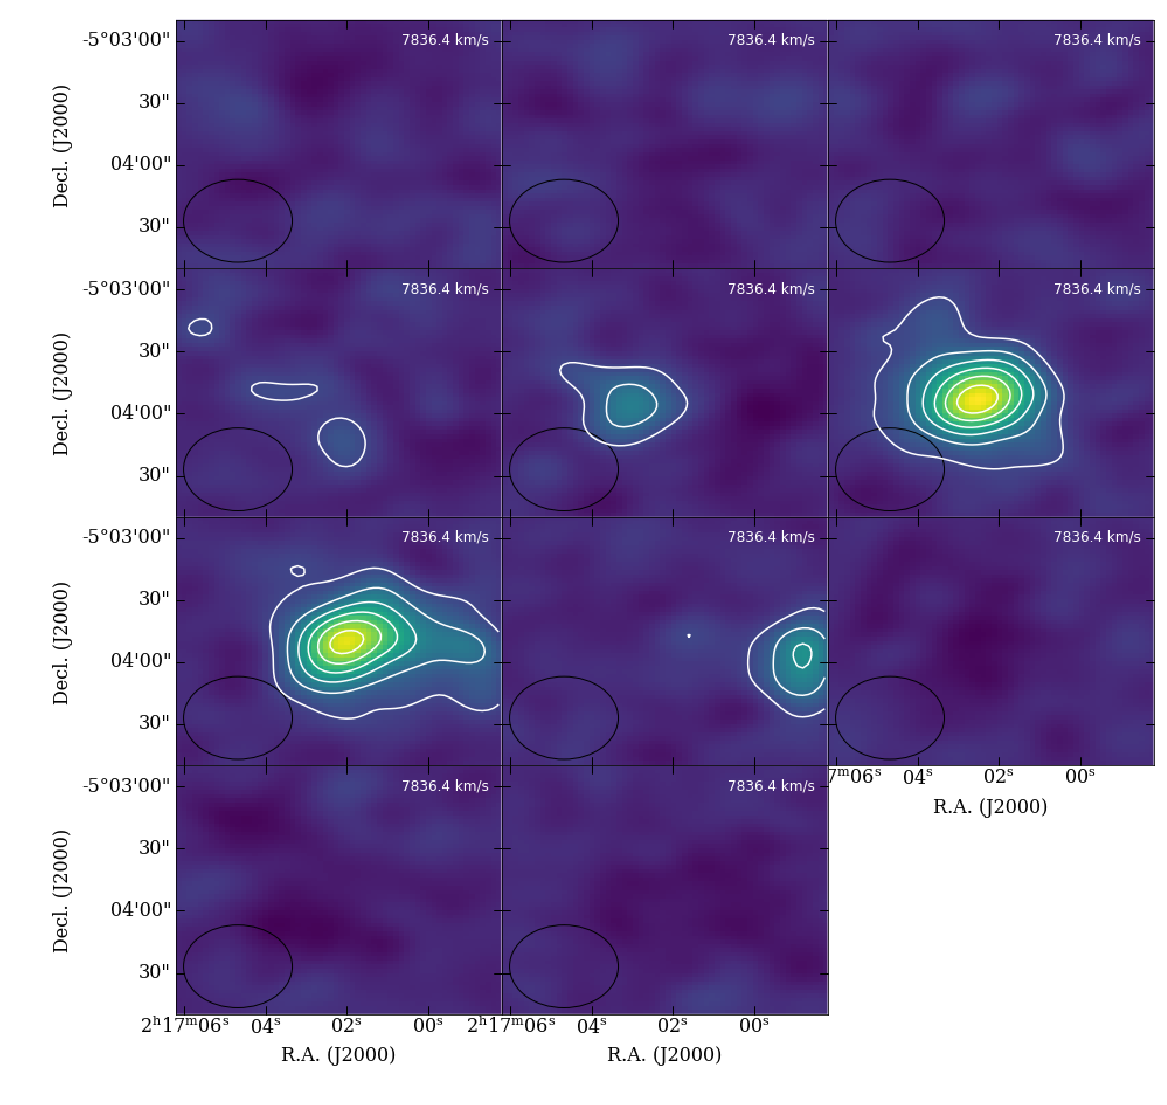

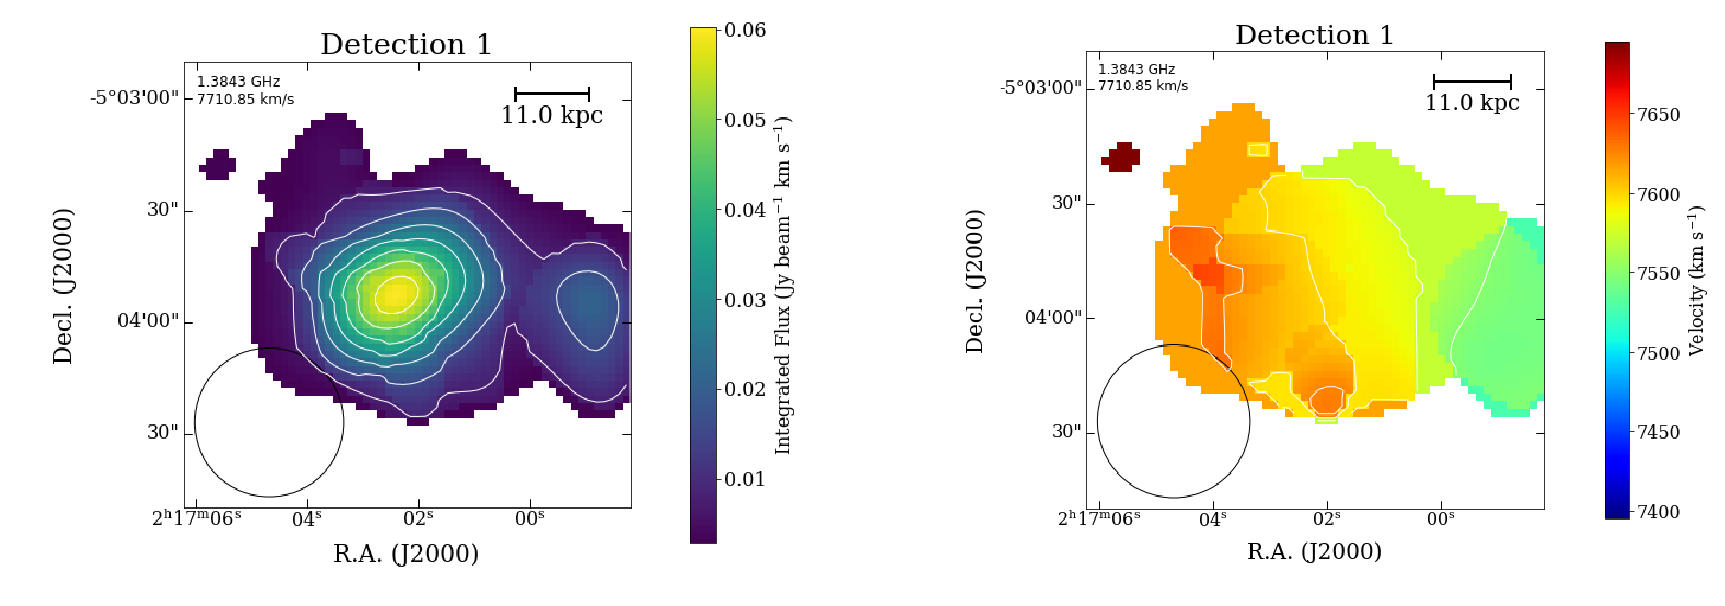

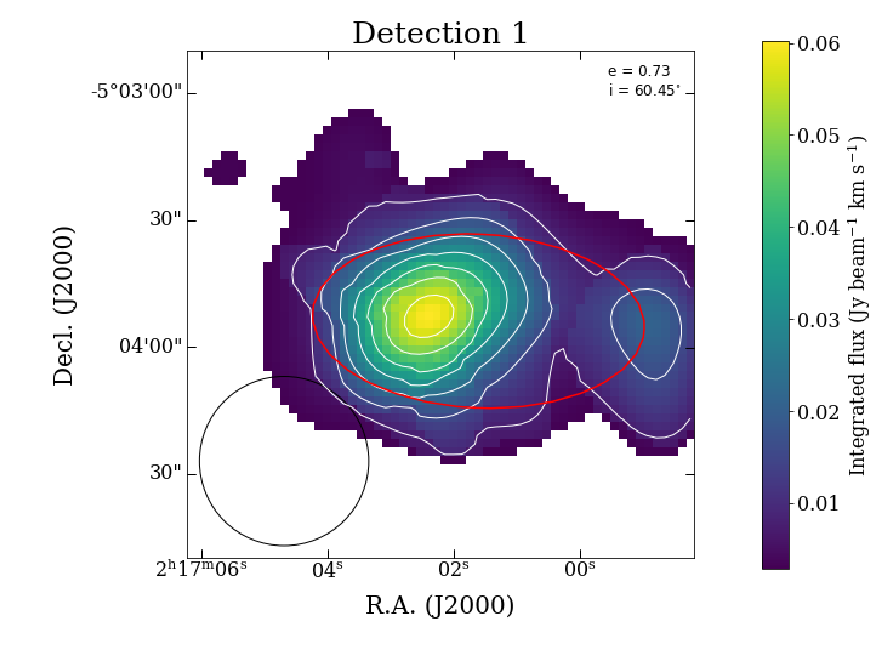

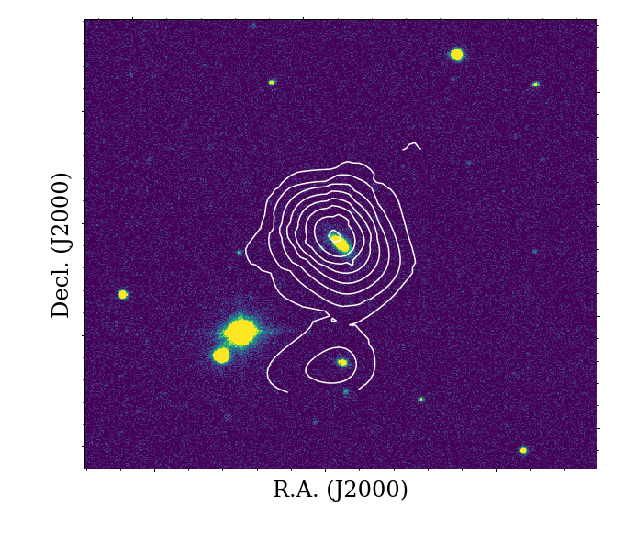

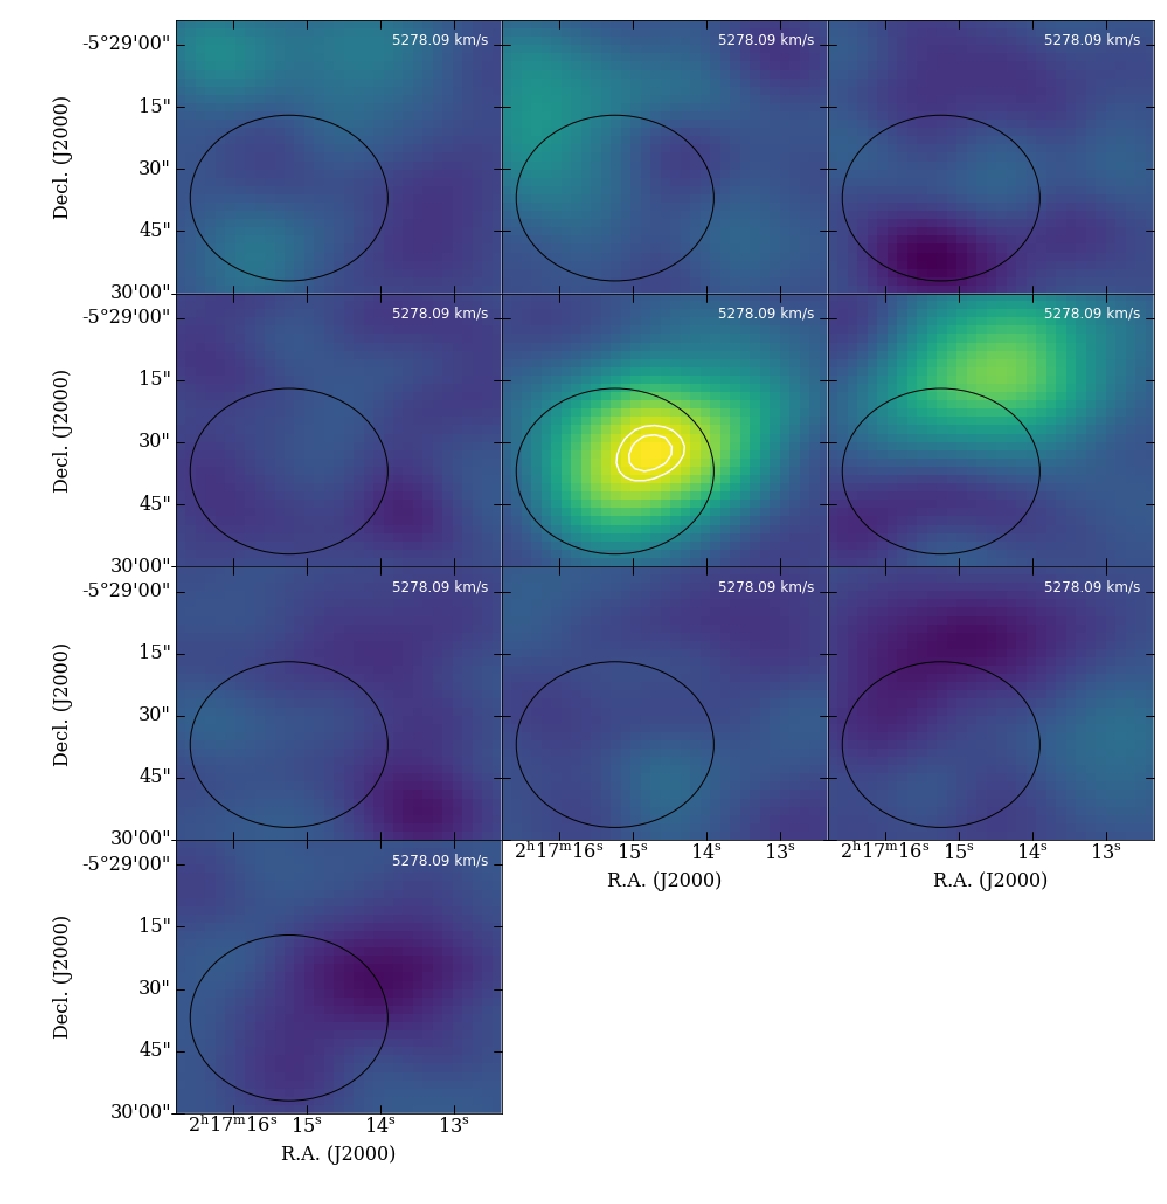

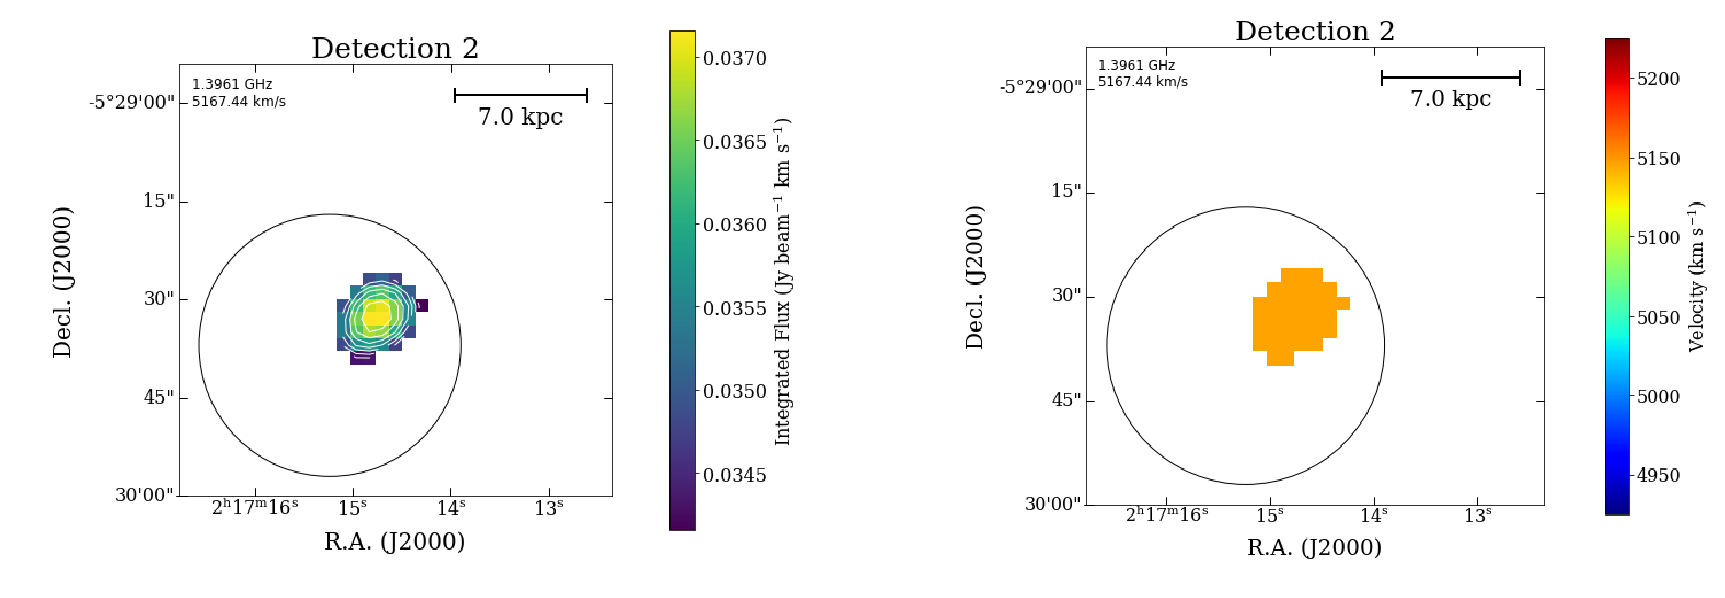

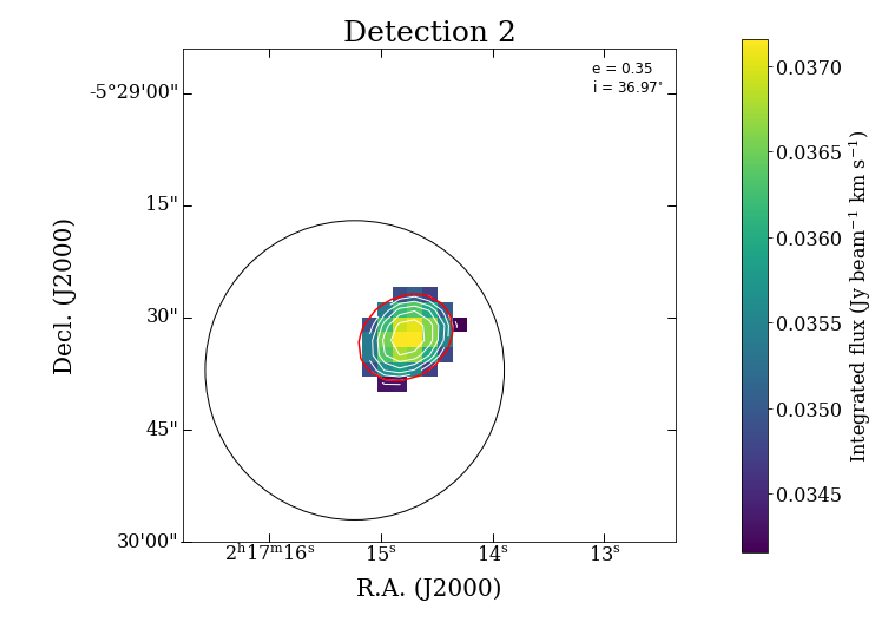

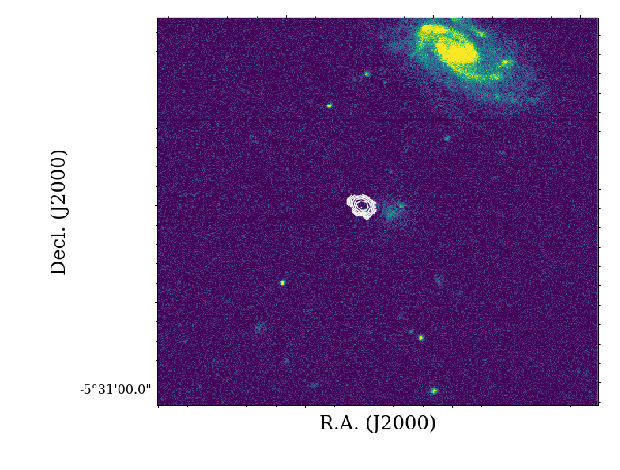

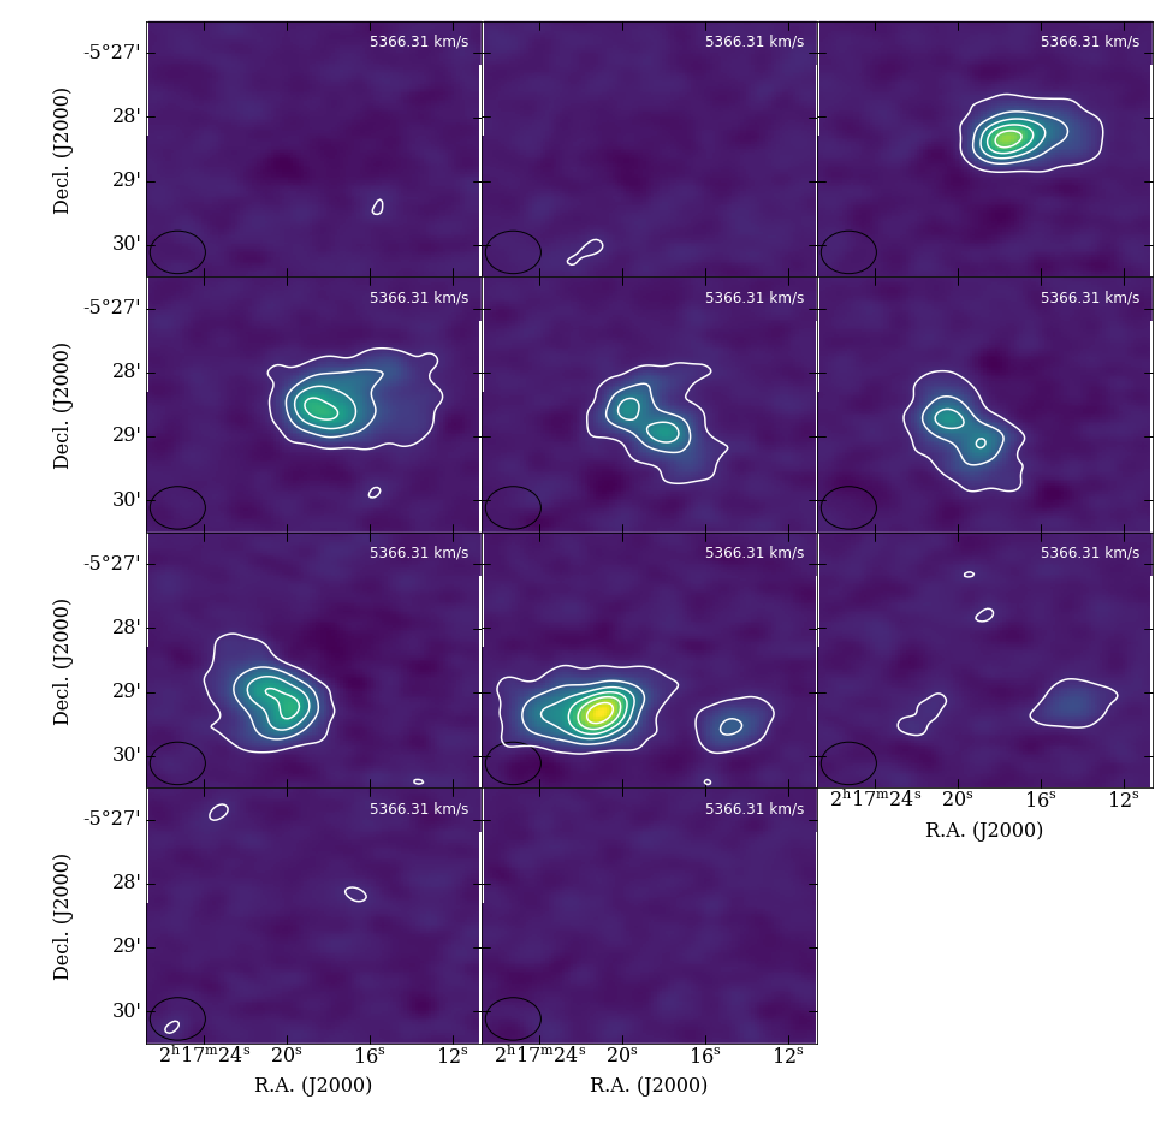

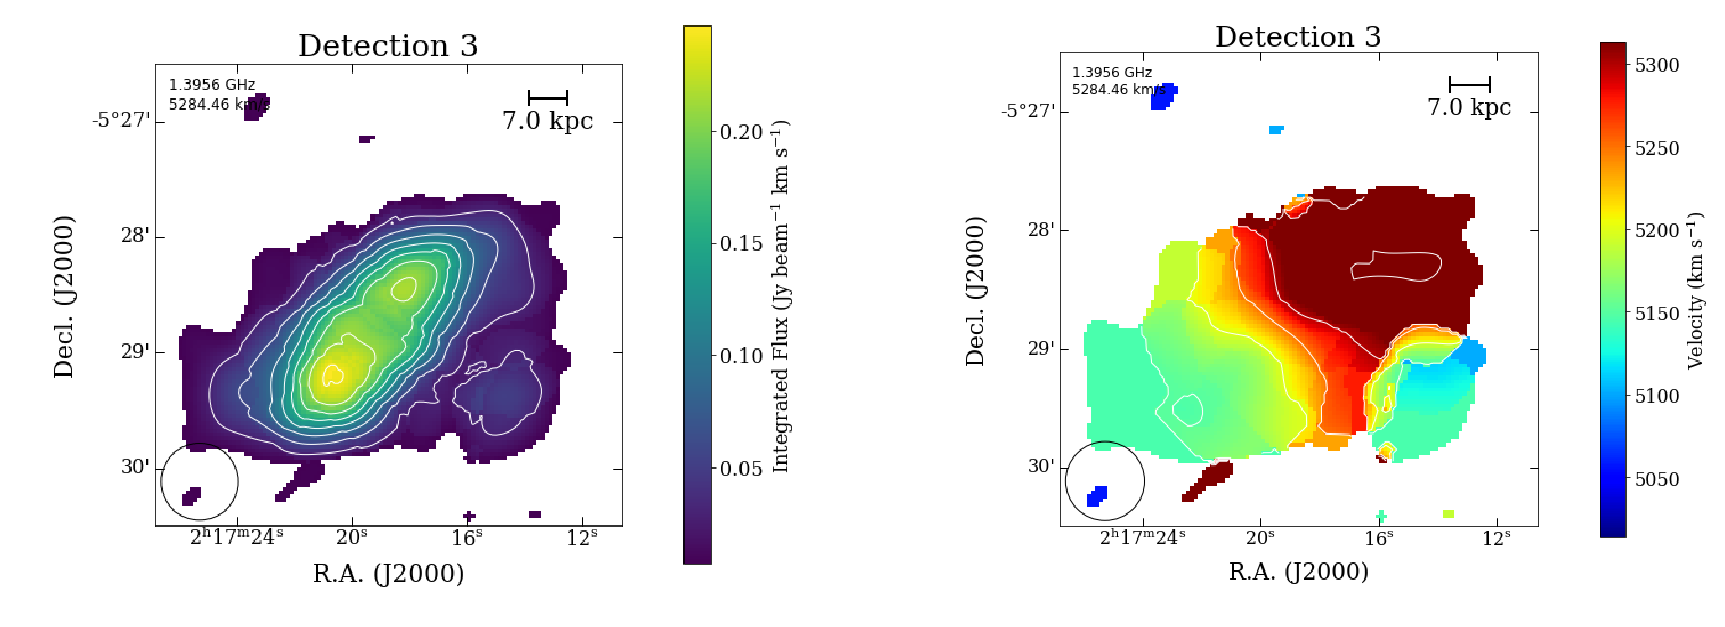

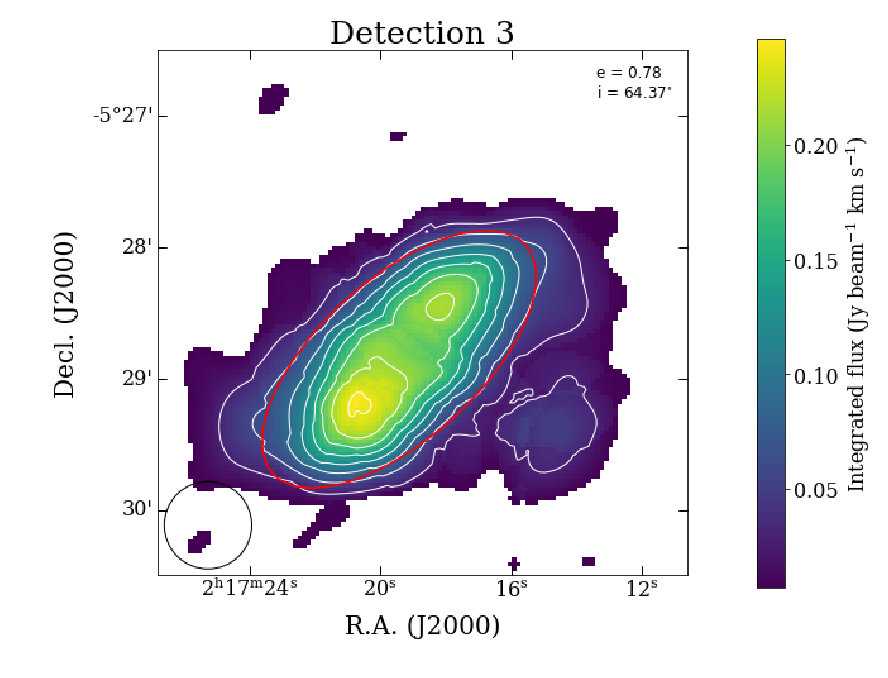

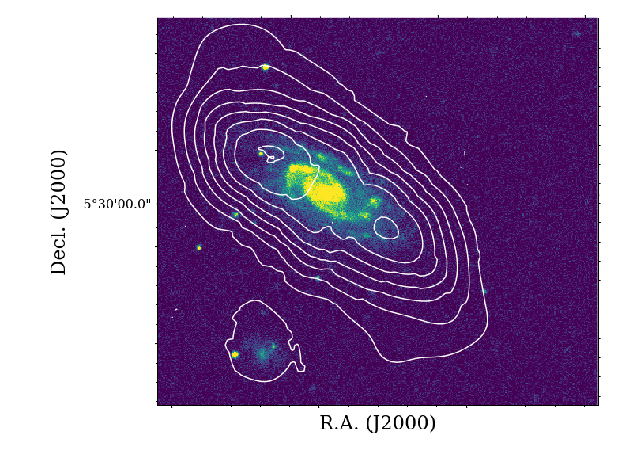

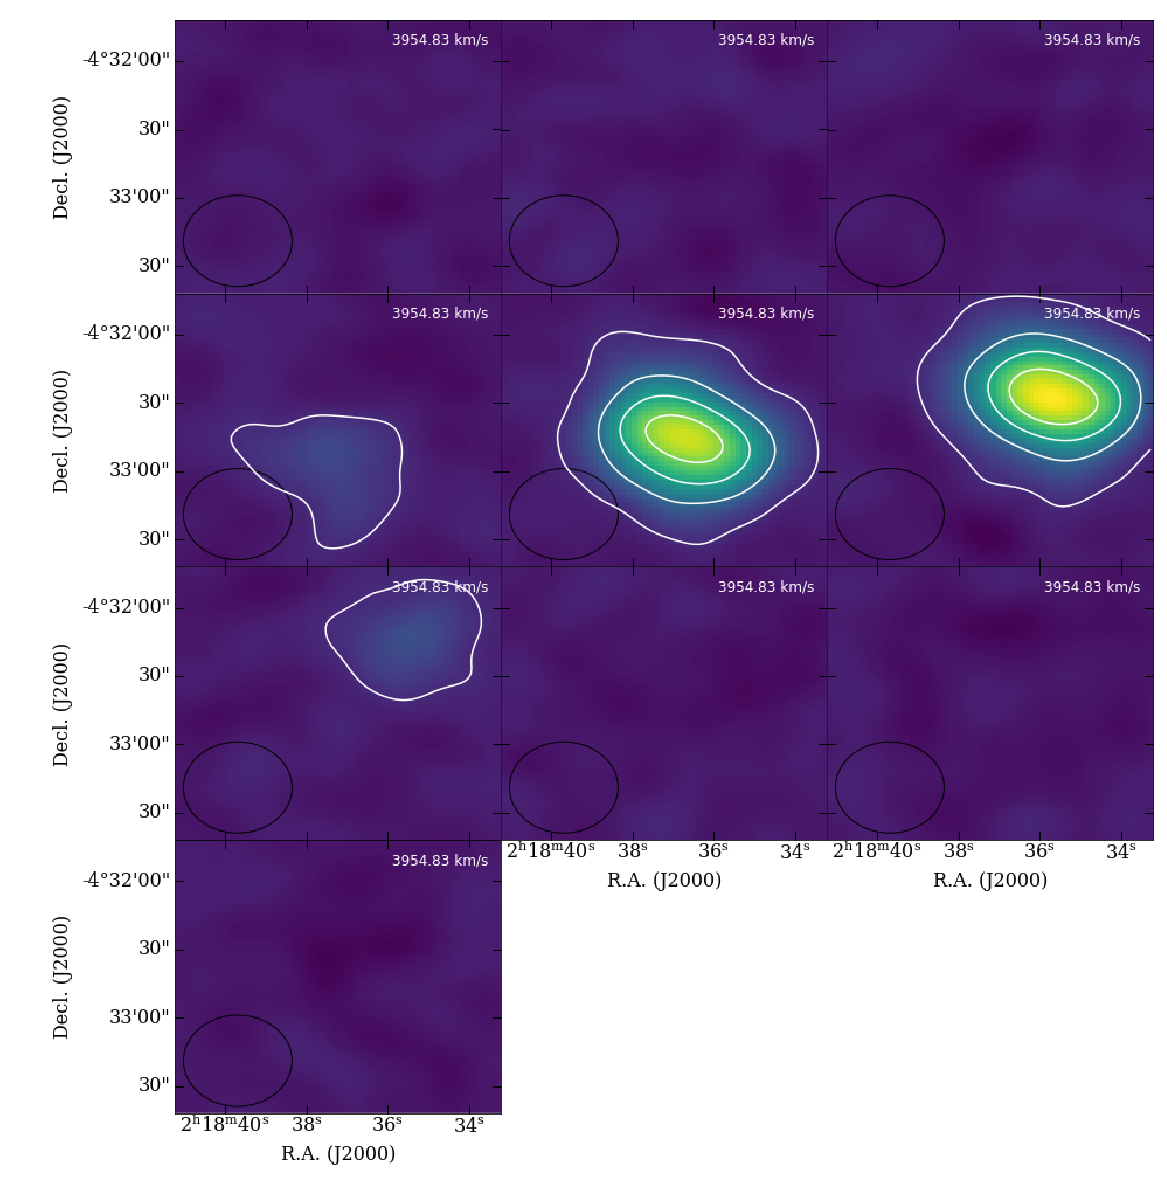

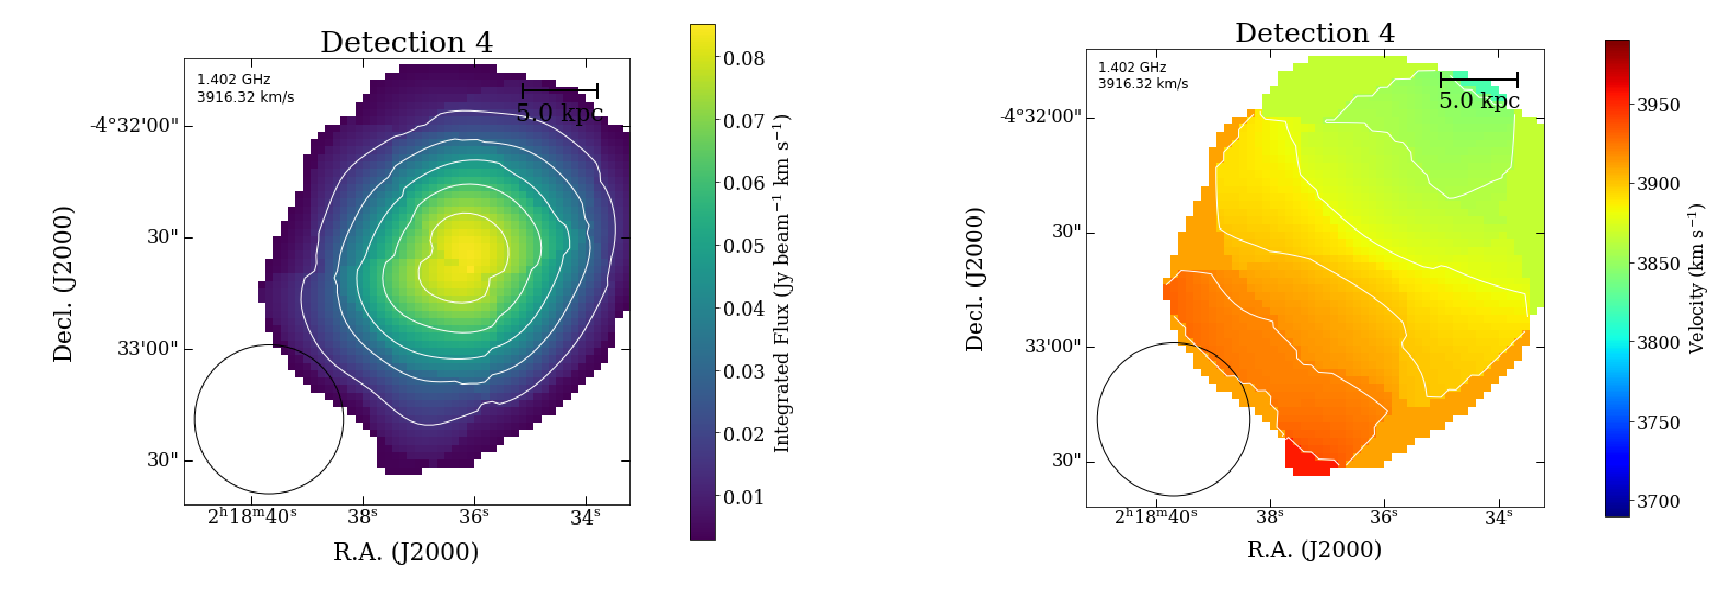

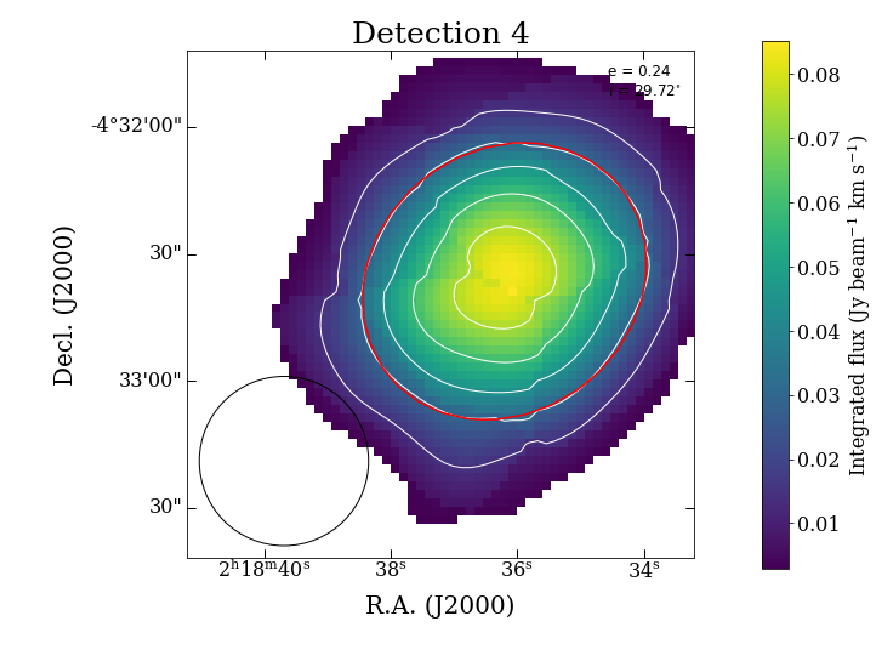

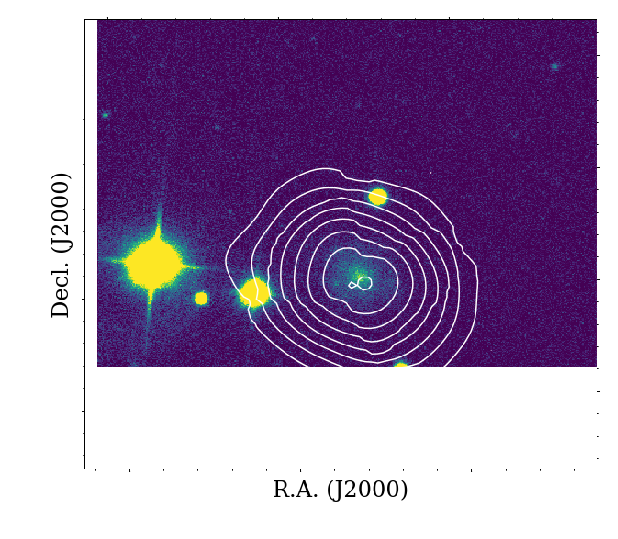

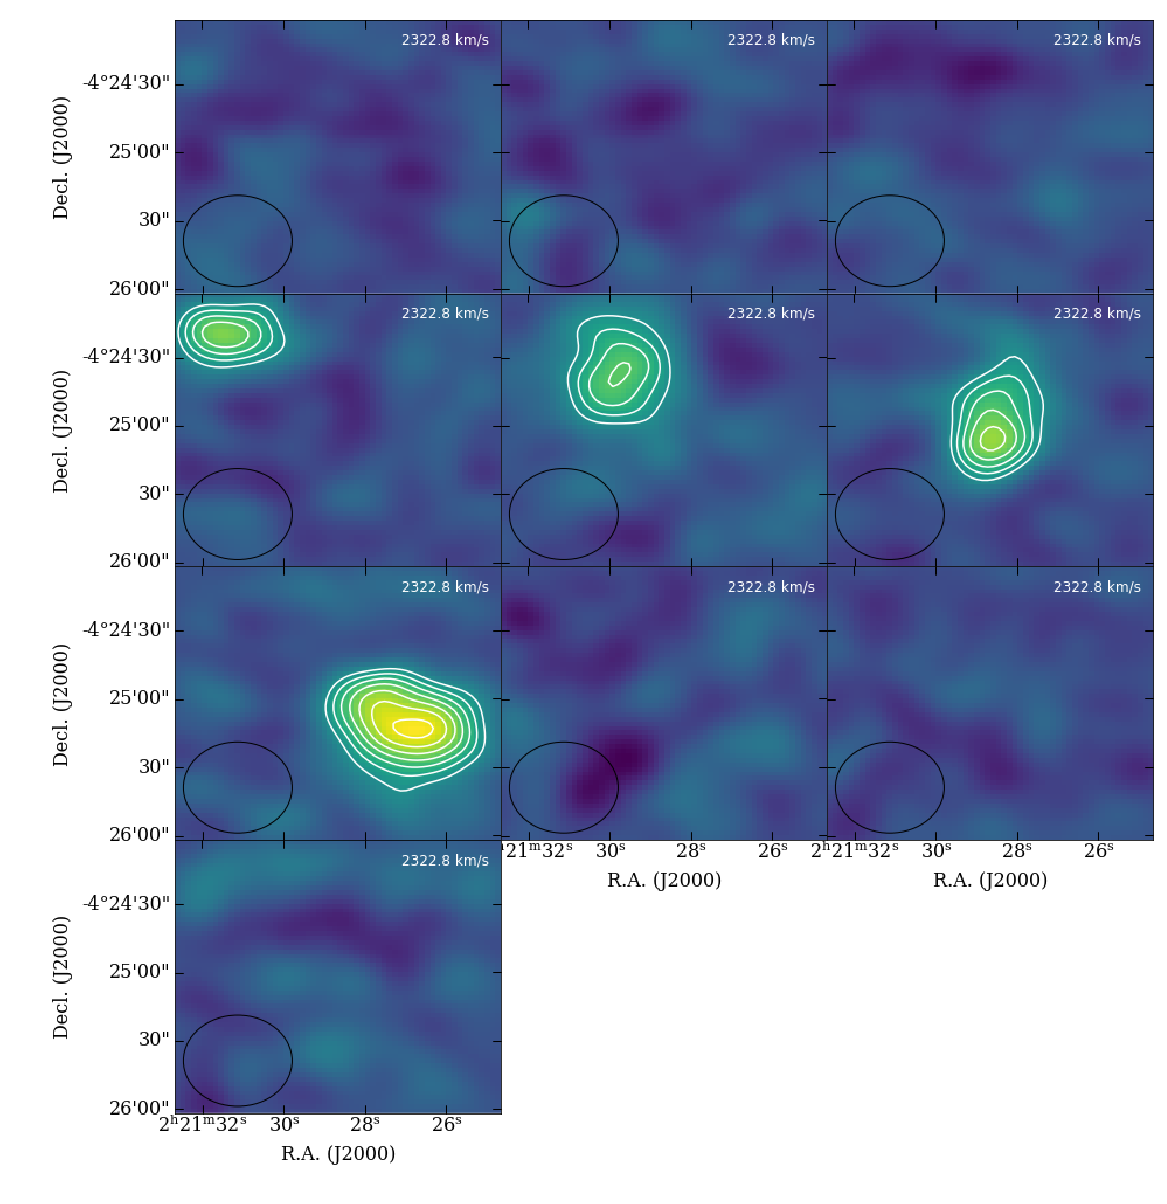

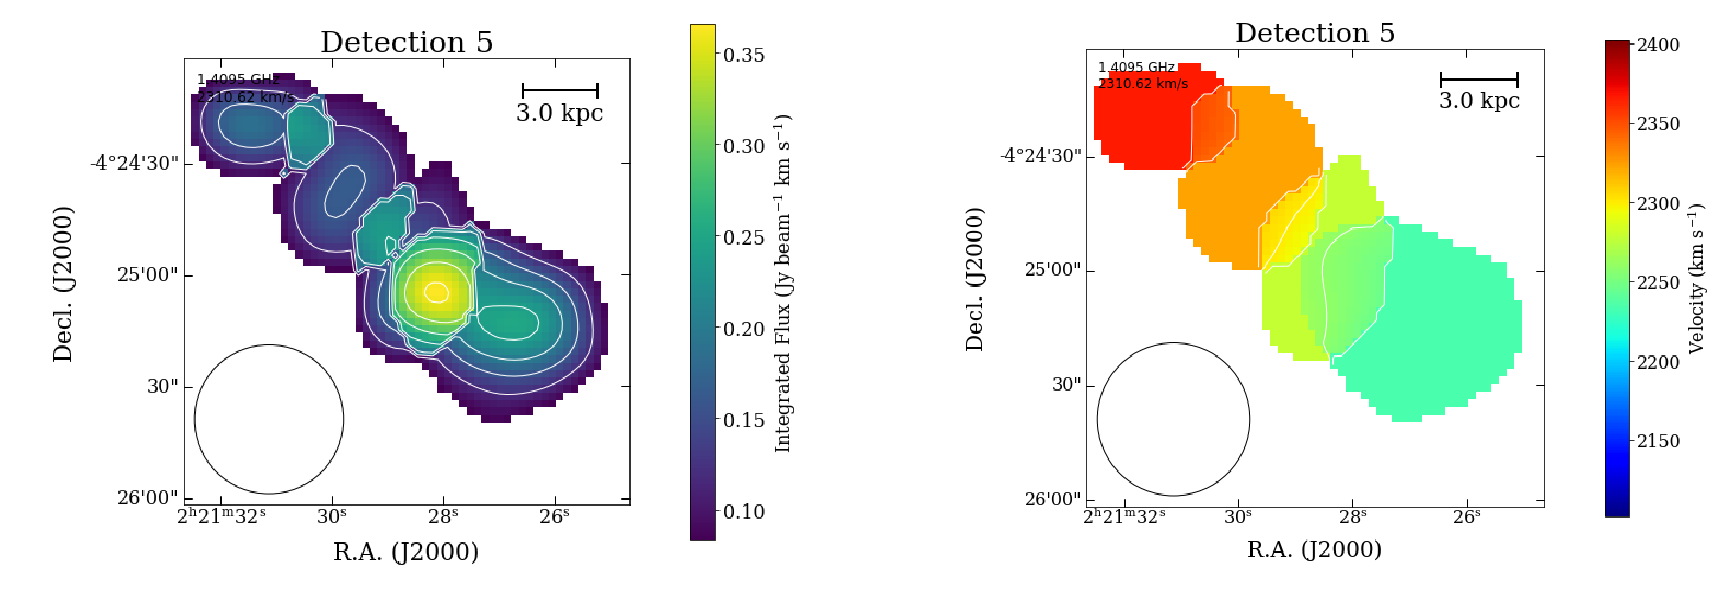

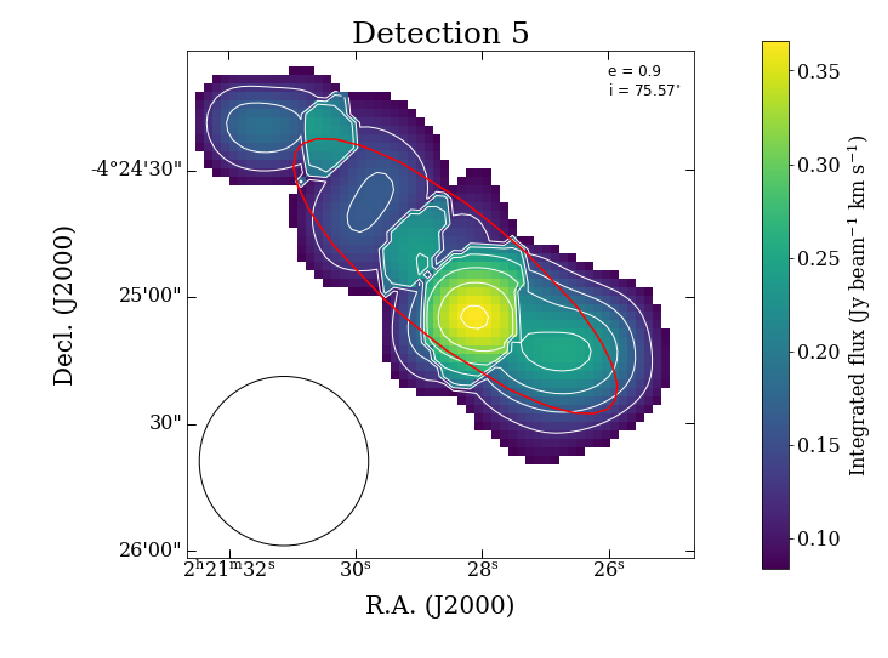

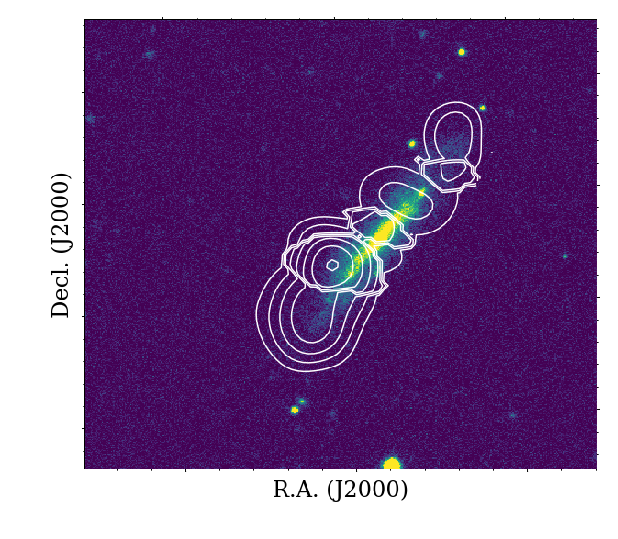

In [29]:
# Showing the results for each detection
for i in range(len(detections)):
    # Channel map
    chan_path = dirName+'/detection_'+str(dets[i])+'/chanmap_det_'+str(dets[i])+'_'+beam_str+'_beam.png'
    
    plt.figure(figsize=(20,50))
    chan_img = mpimg.imread(chan_path)
    plt.imshow(chan_img)
    plt.axis('off')
    plt.show()
    
    # Moment 0 and Moment I maps
    map0_path = dirName+'/detection_'+str(dets[i])+'/mom0_det_'+str(dets[i])+'_'+beam_str+'_beam.png'
    map1_path = dirName+'/detection_'+str(dets[i])+'/mom1_det_'+str(dets[i])+'_'+beam_str+'_beam.png'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,30))
    map0_img = mpimg.imread(map0_path)
    ax1.imshow(map0_img)
    ax1.axis('off')
    
    map1_img = mpimg.imread(map1_path)
    ax2.imshow(map1_img)
    ax2.axis('off')
    
    # Ellipse fitting
    ell_path = dirName+'/detection_'+str(dets[i])+'/ellipse_det_'+str(dets[i])+'_'+beam_str+'_beam.png'
    
    plt.figure(figsize=(15,15))
    ell_img = mpimg.imread(ell_path)
    plt.imshow(ell_img)
    plt.axis('off')
    plt.show()
    
    # SDSS image
    sdss_path = dirName+'/detection_'+str(dets[i])+'/sdss_mom0_det_'+str(dets[i])+'.png'
    
    plt.figure(figsize=(10,10))
    sdss_img = mpimg.imread(sdss_path)
    plt.imshow(sdss_img)
    plt.axis('off')
    plt.show()
    